**Install Packages**

In [7]:
!git clone https://github.com/fizyr/keras-retinanet

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6220, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 6220 (delta 5), reused 6 (delta 2), pack-reused 6205
Receiving objects: 100% (6220/6220), 13.48 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (4205/4205), done.


In [24]:
%cd keras-retinanet
!pip install .
!python setup.py build_ext --inplace

/home/zubair/learning/tableextraction/PDFTableExtract/keras-retinanet
Processing /home/zubair/learning/tableextraction/PDFTableExtract/keras-retinanet
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp38-cp38-linux_x86_64.whl size=180819 sha256=c7d4acfe10e06f783d19329a3a3cdb844a920d8dd2d42de0a4b1241b2cc610b2
  Stored in directory: /home/zubair/.cache/pip/wheels/63/18/8f/2f6d11c020760c8b9e0f0946b631ff05d7065725bf16733f9d
Successfully built keras-retinanet
  Attempting uninstall: keras-retinanet
    Found existing installation: keras-retinanet 1.0.0
    Uninstalling keras-retinan

In [7]:
!pip install PyPDF2

You should consider upgrading via the '/home/zubair/learning/tableextraction/PDFTableExtract/env/bin/python3.8 -m pip install --upgrade pip' command.


In [25]:
%ls

build/           images/           README.md         setup.py
CONTRIBUTORS.md  keras_retinanet/  requirements.txt  snapshots/
examples/        LICENSE           setup.cfg         tests/


In [18]:
#https://buildmedia.readthedocs.org/media/pdf/camelot-py/latest/camelot-py.pdf
!sudo apt install python-tk ghostscript

[sudo] password for zubair: 


In [19]:
!pip install camelot-py[cv]

You should consider upgrading via the '/home/zubair/learning/tableextraction/PDFTableExtract/env/bin/python3.8 -m pip install --upgrade pip' command.


In [20]:
!pip install pdf2image
!apt-get install -y poppler-utils

You should consider upgrading via the '/home/zubair/learning/tableextraction/PDFTableExtract/env/bin/python3.8 -m pip install --upgrade pip' command.
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


**Get Weight and Labels**

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [22]:
!ls

11.pdf		DocumentOCR.ipynb  PDF2Img.ipynb   TrainOCR.ipynb
12.pdf		env		   README.md
build_logos.py	keras-retinanet    RMA_sample.pdf
config		model		   RN2.ipynb


In [5]:
!pip uninstall  keras-resnet

**Import the necessary packages**

In [18]:
from keras_retinanet.utils.image import preprocess_image
from keras_retinanet.utils.image import read_image_bgr
from keras_retinanet.utils.image import resize_image
from keras_retinanet import models

from pdf2image import convert_from_path
import matplotlib.pyplot as plt
from PyPDF2 import PdfFileWriter, PdfFileReader

import numpy as np
import cv2
import camelot
import copy

ModuleNotFoundError: No module named 'keras_retinanet'

**Load Label and Weight**

In [27]:
# load the class label mappings
#model for headers
#labels = '/content/gdrive/My Drive/Colab Notebooks/retinanet_classes_RN3.csv'

#model for table
labels = '/home/zubair/learning/tableextraction/PDFTableExtract/model/retinanet_classes.csv'

LABELS = open(labels).read().strip().split("\n")
print(LABELS)
LABELS = {int(L.split(",")[1]): L.split(",")[0] for L in LABELS}
print(LABELS)

['table,0', 'person,1', 'signature,2']
{0: 'table', 1: 'person', 2: 'signature'}


In [ ]:
import pyximport
pyximport.install()

In [33]:
# load the weight from disk

#model for headers
#model_path = '/content/gdrive/My Drive/Colab Notebooks/output_RN3.h5'

#model for table
model_path = '/home/zubair/learning/tableextraction/PDFTableExtract/model/output_table.h5'

model = models.load_model(model_path, backbone_name='resnet50')

**Functions**

In [34]:
def norm_pdf_page(pdf_file, pg):
    pdf_doc = PdfFileReader(open(pdf_file, "rb"))
    pdf_page = pdf_doc.getPage(pg-1)
    pdf_page.cropBox.upperLeft = (0, list(pdf_page.mediaBox)[-1])
    pdf_page.cropBox.lowerRight = (list(pdf_page.mediaBox)[-2], 0)
    return pdf_page

def pdf_page2img(pdf_file, pg, save_image=True):
    img_page = convert_from_path(pdf_file, first_page=pg, last_page=pg)[0]
    if save_image:
        img=pdf_file[:-4]+"-"+str(pg)+".jpg"
        img_page.save(img)
    return np.array(img_page), img

def img_dim(img, bbox):
    H_img,W_img,_=img.shape
    x1_img, y1_img, x2_img, y2_img=bbox
    w_table, h_table=x2_img-x1_img, y2_img-y1_img
    return [[x1_img, y1_img, x2_img, y2_img], [w_table, h_table], [H_img,W_img]]

def norm_bbox(img, bbox, x_corr=0.05, y_corr=0.05):
    [[x1_img, y1_img, x2_img, y2_img], [w_table, h_table], [H_img,W_img]]=img_dim(img, bbox)
    x1_img_norm,y1_img_norm,x2_img_norm,y2_img_norm=x1_img/W_img, y1_img/H_img, x2_img/W_img, y2_img/H_img
    w_img_norm, h_img_norm=w_table/W_img, h_table/H_img
    w_corr=w_img_norm*x_corr
    h_corr=h_img_norm*x_corr

    return [x1_img_norm-w_corr,y1_img_norm-h_corr/2,x2_img_norm+w_corr,y2_img_norm+2*h_corr]

def bboxes_pdf(img, pdf_page, bbox, save_cropped=False):
    W_pdf=float(pdf_page.cropBox.getLowerRight()[0])
    H_pdf=float(pdf_page.cropBox.getUpperLeft()[1])
    print(bbox)

    [x1_img_norm,y1_img_norm,x2_img_norm,y2_img_norm]=norm_bbox(img, bbox)
    x1, y1 = x1_img_norm*W_pdf, (1-y1_img_norm)*H_pdf
    x2, y2 = x2_img_norm*W_pdf, (1-y2_img_norm)*H_pdf
    
    if save_cropped:
        page=copy.copy(pdf_page)
        page.cropBox.upperLeft = (x1, y1)
        page.cropBox.lowerRight = (x2, y2)
        output = PdfFileWriter()
        output.addPage(page)

        with open(pdf_file[:-4]+"-"+str(pg)+".pdf", "wb") as out_f:
            output.write(out_f)

    return [x1, y1, x2, y2]
    
def detect_table(imgfname):
    image_path = imgfname
    image = read_image_bgr(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
    
    image = preprocess_image(image)
    (image, scale) = resize_image(image)
    image = np.expand_dims(image, axis=0)

    # detect objects in the input image and correct for the image scale

    (boxes, scores, labels) = model.predict_on_batch(image)
    boxes /= scale

    confidence = 0.2
    label_out = []

    # loop over the detections

    for (box, score, label) in zip(boxes[0], scores[0], labels[0]):

        # filter out weak detections

        if score < confidence:
            continue

        # convert the bounding box coordinates from floats to integers
        box = box.astype('int')

        # build the label and draw the label + bounding box on the output image
        labeli = label

        if LABELS[labeli] not in label_out:
          label_out.append(LABELS[labeli])
          print(box)

          return (box[0], box[1], box[2], box[3])	

**Import PDF File to extract the information**

In [54]:
# Upload PDF File
page = 1
PDF_PATH = '/home/zubair/learning/tableextraction/PDFTableExtract/11.pdf'

In [55]:
img_page = convert_from_path(PDF_PATH, first_page=page, last_page=page+1, output_folder="/home/zubair/learning/tableextraction/PDFTableExtract/content/", fmt="jpg")
pdf_file = PDF_PATH
pg = page
img, imgfname = pdf_page2img(pdf_file, pg, save_image=True)

**Prediction using Keras RetinaNet**

(517, 423, 3)
table: 1.00
30
193
393
406


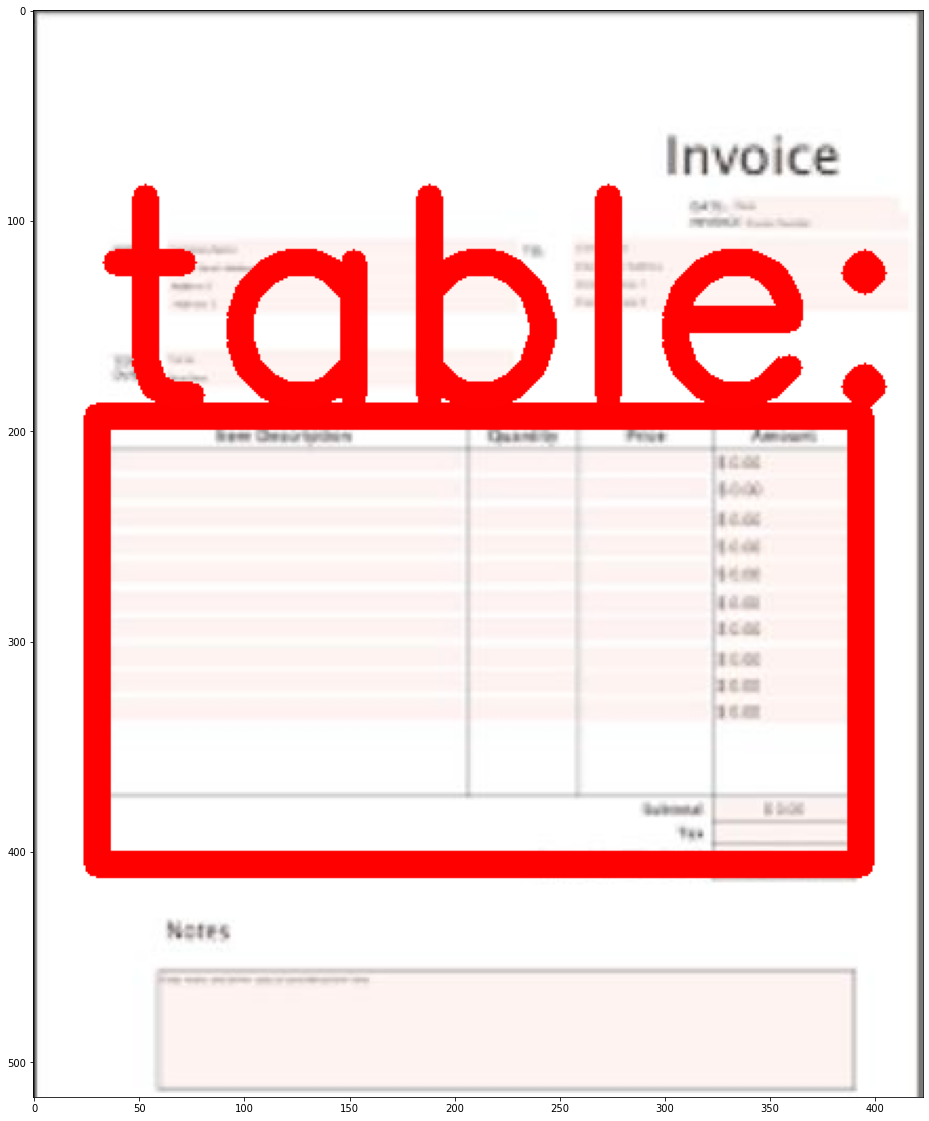

In [56]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

image_path = imgfname
#image = cv2.imread(image_path)
image = read_image_bgr(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

output = image.copy()
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
print(output.shape) # row (height) x column (width) x color (3)

image = preprocess_image(image)
(image, scale) = resize_image(image)
image = np.expand_dims(image, axis=0)

# detect objects in the input image and correct for the image scale
(boxes, scores, labels) = model.predict_on_batch(image)
boxes /= scale

confidence =  0.2
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
label_out = []
result = ""

# loop over the detections
for (box, score, label) in zip(boxes[0], scores[0], labels[0]):
	# filter out weak detections
	if score < confidence:
		continue

	# convert the bounding box coordinates from floats to integers
	box = box.astype("int")

	# build the label and draw the label + bounding box on the output
	# image
	labeli = label
	label = "{}: {:.2f}".format(LABELS[label], score)
	print(label)
	
	if LABELS[labeli] not in label_out:
	    label_out.append(LABELS[labeli])
	    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 12)
	    print(box[0])
	    print(box[1])
	    print(box[2])
	    print(box[3])
	    #result 		 
	    cv2.putText(output, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4.5, (255, 1, 1), 12)
     	    
plt.figure(figsize=(20, 20))
plt.imshow(output)
plt.show()

**Get Table**

In [57]:
pdf_page=norm_pdf_page(PDF_PATH, pg)

In [58]:
x1, y1, x2, y2 = detect_table(imgfname)
x1, y1, x2, y2

[ 30 193 393 406]


(30, 193, 393, 406)

In [59]:
interesting_areas=[]

output = [[x1, y1, x2, y2]]
for x in output:
  [x1, y1, x2, y2] = bboxes_pdf(img, pdf_page, x)
  bbox_camelot = [
            ",".join([str(x1), str(y1), str(x2), str(y2)])
        ][0]  # x1,y1,x2,y2 where (x1, y1) -> left-top and (x2, y2) -> right-bottom in PDF coordinate space
        #print(bbox_camelot)
  interesting_areas.append(bbox_camelot)


print(interesting_areas)
output_camelot = camelot.read_pdf(
    filepath=pdf_file, pages=str(pg), flavor="stream", table_areas=interesting_areas
)

output_camelot[0].df

#output_camelot=[x.df for x in output_camelot]
#for i,db in enumerate(output_camelot):
#  db.to_excel(pdf_file[:-4]+"-"+str(pg)+"-table-"+str(i)+".xlsx")

[30, 193, 393, 406]
['4.265159574468085,118.48056092843328,147.98484042553193,32.271179883945855']


/home/zubair/.local/lib/python3.10/site-packages/camelot/parsers/stream.py:448: UserWarning: page-1 is image-based, camelot only works on text-based pages.
  warnings.warn(


IndexError: list index out of range

In [62]:
!ls

build		 images		  README.md	    setup.py
CONTRIBUTORS.md  keras_retinanet  requirements.txt  snapshots
examples	 LICENSE	  setup.cfg	    tests


In [13]:
import camelot
tables = camelot.read_pdf(filepath='/home/zubair/learning/tableextraction/PDFTableExtract/13o.pdf',pages=str(0),flavor="lattice")
tables


<TableList n=2>

In [17]:

#ables.export('foo.csv', f='csv', compress=True) # json, excel, html, markdown, sqlite
print(tables[2].df)

IndexError: list index out of range

In [74]:
!pip install tabula-py

  Using cached tabula_py-2.5.1-py3-none-any.whl (12.0 MB)
You should consider upgrading via the '/home/zubair/learning/tableextraction/PDFTableExtract/env/bin/python3.8 -m pip install --upgrade pip' command.


In [78]:
import tabula

# Read pdf into list of DataFrame
dfs = tabula.read_pdf("/home/zubair/learning/tableextraction/PDFTableExtract/12.pdf", pages='all')

# Read remote pdf into list of DataFrame
#dfs2 = tabula.read_pdf("https://github.com/tabulapdf/tabula-java/raw/master/src/test/resources/technology/tabula/arabic.pdf")


In [79]:
dfs

[  Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Percent Fuel Savings Unnamed: 4
 0      Cycle         KI   Distance        NaN                  NaN        NaN
 1       Name     (1/km)       (mi)   Improved  Decreased Eliminate  Decreased
 2        NaN        NaN        NaN      Speed          Accel Stops       Idle
 3     2012_2       3.30        1.3       5.9%           9.5% 29.2%      17.4%
 4     2145_1       0.68       11.2       2.4%            0.1% 9.5%       2.7%
 5     4234_1       0.59       58.7       8.5%            1.3% 8.5%       3.3%
 6     2032_2       0.17       57.8      21.7%            0.3% 2.7%       1.2%
 7     4171_1       0.07      173.9      58.1%            1.6% 2.1%       0.5%]

In [4]:
%pip install tesseract

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 45.3 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562571 sha256=f72f53e0c019130b4e662f79b10724fa9f8f75a938c4484211e24ab217eba125
  Stored in directory: /home/zubair/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ocrmypdf



In [12]:
ocrmypdf.ocr('/home/zubair/learning/tableextraction/PDFTableExtract/11.pdf', '13o.pdf', deskew=True)

Scanning contents: 100%|███████████████████████| 1/1 [00:00<00:00, 643.20page/s]
OCR: 100%|██████████████████████████████████| 1.0/1.0 [00:00<00:00,  5.60page/s]
PDF/A conversion: 100%|█████████████████████████| 1/1 [00:00<00:00, 13.36page/s]
Recompressing JPEGs: 0image [00:00, ?image/s]
Deflating JPEGs: 100%|███████████████████████| 1/1 [00:00<00:00, 1702.23image/s]
JBIG2: 0item [00:00, ?item/s]


<ExitCode.ok: 0>